In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

In [3]:
x_train = pd.read_csv(os.path.join('train.csv'))
x_train = x_train.drop('label', axis=1)
x_train = x_train.values

x_test = pd.read_csv(os.path.join('test.csv'))
x_test = x_test.values

input_dim = np.prod(x_train.shape[1:])

x_train = x_train.astype(np.float32) / 255.
x_train = x_train.reshape((x_train.shape[0], input_dim))
x_test = x_test.astype(np.float32) / 255.
x_test = x_test.reshape((x_test.shape[0], input_dim))

In [4]:
print(f"The input dimension is {input_dim} because image have 28x28=784 pixels")

The input dimension is 784 because image have 28x28=784 pixels


In [5]:
#The dimensionality of the encoded representation.
encoded_dim = 32
#Size and number of hidden layers.
hidden_layer_weights = [392, 196, 98]
hidden_layers = len(hidden_layer_weights)

In [6]:
def construct_encoder(input, layers, encoded_dim, units):
    x = None
    for i in range(layers):
        x = keras.layers.Dense(units[i], activation='relu')(input if x is None else x)
    return keras.layers.Dense(encoded_dim, activation='relu')(x)

def construct_decoder(input, layers, input_dim, units):
    x = None
    for i in range(layers):
        x = keras.layers.Dense(units[i], activation='relu')(input if x is None else x)
    return keras.layers.Dense(input_dim, activation='sigmoid')(x)

# Create a new stack of layers from existing layers with new input layer.
def add_new_input(input, layers):
    new_layer_stack = input
    for layer in layers:
        new_layer_stack = layer(new_layer_stack)
    return new_layer_stack

In [7]:
# Input to encoder.
input = keras.layers.Input(shape=(input_dim,))
# Create encoder half.
encoded_layer = construct_encoder(input, hidden_layers, encoded_dim, hidden_layer_weights)
# Create decoder half.
decoded_layer = construct_decoder(encoded_layer, hidden_layers, input_dim, list(reversed(hidden_layer_weights)))

# Assemble full autoencoder model.
model = keras.models.Model(input, decoded_layer)

# Assemble encoder model.
encoder = keras.models.Model(input, encoded_layer)

# Assemble decoder model.
decoder_input = keras.layers.Input(shape=(encoded_dim,))
decoder = keras.models.Model(decoder_input, add_new_input(decoder_input, model.layers[-(hidden_layers + 1):]))

In [8]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_crossentropy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 392)               307720    
_________________________________________________________________
dense_1 (Dense)              (None, 196)               77028     
_________________________________________________________________
dense_2 (Dense)              (None, 98)                19306     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                3168      
_________________________________________________________________
dense_4 (Dense)              (None, 98)                3234      
_________________________________________________________________
dense_5 (Dense)              (None, 196)               19404 

In [9]:
model.fit(x_train, x_train, epochs=25)

Epoch 1/25
1313/1313 [==============================] - 6s 4ms/step - loss: 0.2100 - binary_crossentropy: 0.2100
Epoch 2/25
1313/1313 [==============================] - 6s 4ms/step - loss: 0.1184 - binary_crossentropy: 0.1184
Epoch 3/25
1313/1313 [==============================] - 5s 4ms/step - loss: 0.1069 - binary_crossentropy: 0.1069
Epoch 4/25
1313/1313 [==============================] - 5s 4ms/step - loss: 0.1014 - binary_crossentropy: 0.1014
Epoch 5/25
1313/1313 [==============================] - 5s 4ms/step - loss: 0.0976 - binary_crossentropy: 0.0976
Epoch 6/25
1313/1313 [==============================] - 5s 4ms/step - loss: 0.0950 - binary_crossentropy: 0.0950
Epoch 7/25
1313/1313 [==============================] - 5s 4ms/step - loss: 0.0927 - binary_crossentropy: 0.0927
Epoch 8/25
1313/1313 [==============================] - 5s 4ms/step - loss: 0.0914 - binary_crossentropy: 0.0914
Epoch 9/25
1313/1313 [==============================] - ETA: 0s - loss: 0.0902 - binary_crossent

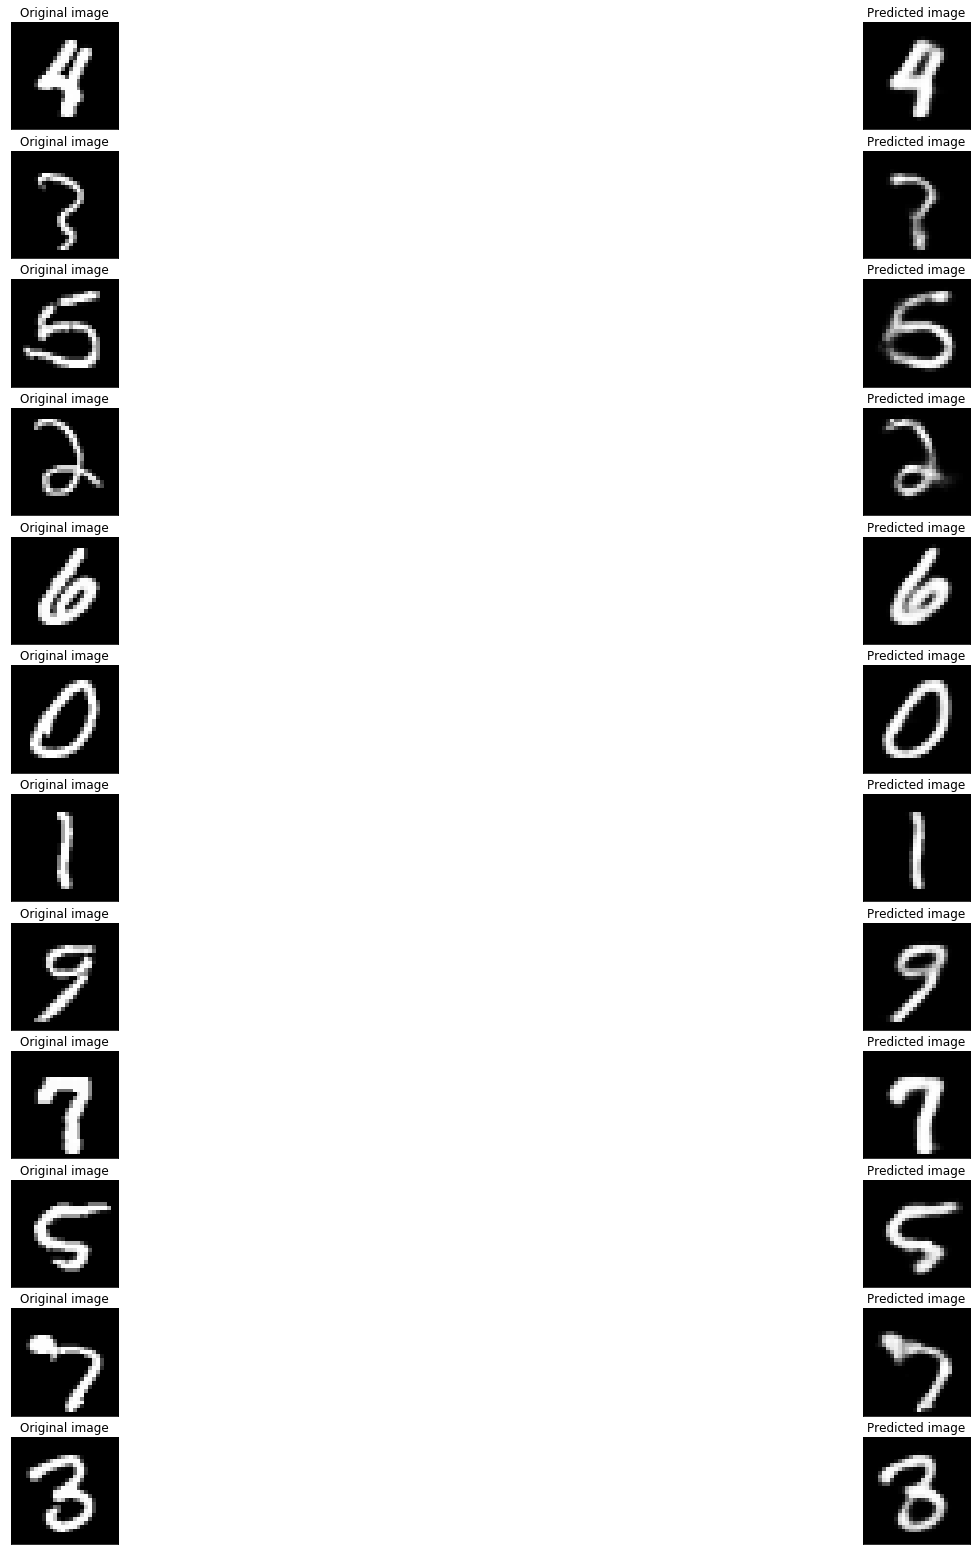

In [10]:
#setting the number of images represented and randomisation of test data index
vis_num = 12
vis_start_index = np.random.randint(0, len(x_test))

fig, axes = plt.subplots(vis_num, 2)
for i in range(vis_num):
    test_index = vis_start_index + i
    x_encoded = encoder.predict(x_test[test_index].reshape(1, -1))
    x_predicted = decoder.predict(x_encoded)
    encoded_columns = 2
    plt.gray()

    #Plotting of the predicted image
    axes_predicted = axes[i][1]
    axes_predicted.imshow(x_predicted.reshape((28, 28)))
    axes_predicted.title.set_text('Predicted image')
    axes_predicted.get_xaxis().set_visible(False)
    axes_predicted.get_yaxis().set_visible(False)
    
    #Plotting the original x_test image
    axes_original = axes[i][0]
    axes_original.imshow(x_test[test_index].reshape((28, 28)))
    axes_original.title.set_text('Original image')
    axes_original.get_xaxis().set_visible(False)
    axes_original.get_yaxis().set_visible(False)

    #setting the image size and displaying
fig.set_size_inches(28, 28)
plt.show()